In [0]:
# Only run once or when libraries are missing
%pip install networkx folium graphframes


Python interpreter will be restarted.
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Not uninstalling jinja2 at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-8c4b342d-0efd-45d4-bda3-b5c29dfc273d
    Can't uninstall 'Jinja2'. No files were found to uninstall.
Python interpreter will be restarted.


In [0]:
from pyspark.sql.functions import (
    col, to_timestamp, hour, dayofweek, dayofmonth, month, when, 
    count, approx_count_distinct, unix_timestamp, sum as _sum, 
    lag, avg, isnan, to_date, lit, countDistinct
)

from pyspark.sql import Window, functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, Imputer, SQLTransformer, FeatureHasher
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation      import BinaryClassificationEvaluator
import numpy as np

from pyspark.sql.functions import col, count

from pyspark.sql.functions import substring
from graphframes import GraphFrame

import networkx as nx
import matplotlib.pyplot as plt
from pyspark.sql.functions import col


from collections import defaultdict
import seaborn as sns



In [0]:
data = spark.read.option("header", True).option("inferSchema", True) \
    .csv("/FileStore/tables/financial_fraud_detection_dataset-1.csv")

In [0]:
display(dbutils.fs.ls("/FileStore/tables/"))


path,name,size,modificationTime
dbfs:/FileStore/tables/financial_fraud_detection_dataset-1.csv,financial_fraud_detection_dataset-1.csv,796050204,1747415740000
dbfs:/FileStore/tables/financial_fraud_detection_dataset.csv,financial_fraud_detection_dataset.csv,796050204,1747415310000


### 1. Initial Analysis

In [0]:
data.limit(10).display()

transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash
T100000,2023-08-22T09:22:43.516+0000,ACC877572,ACC388389,343.78,withdrawal,utilities,Tokyo,mobile,false,null,null,-0.21,3,0.22,card,13.101.214.112,D8536477
T100001,2023-08-04T01:58:02.606+0000,ACC895667,ACC944962,419.65,withdrawal,online,Toronto,atm,false,null,null,-0.14,7,0.96,ACH,172.52.47.194,D2622631
T100002,2023-05-12T11:39:33.742+0000,ACC733052,ACC377370,2773.86,deposit,other,London,pos,false,null,null,-1.78,20,0.89,card,185.98.35.23,D4823498
T100003,2023-10-10T06:04:43.195+0000,ACC996865,ACC344098,1666.22,deposit,online,Sydney,pos,false,null,null,-0.6,6,0.37,wire_transfer,107.136.36.87,D9961380
T100004,2023-09-24T08:09:02.700+0000,ACC584714,ACC497887,24.43,transfer,utilities,Toronto,mobile,false,null,null,0.79,13,0.27,ACH,108.161.108.255,D7637601
T100005,2023-11-20T17:49:27.940+0000,ACC581141,ACC249811,58.77,transfer,entertainment,Berlin,atm,false,null,null,-1.63,19,0.4,UPI,112.70.252.46,D1790481
T100006,2023-11-11T11:15:41.359+0000,ACC757924,ACC267753,59.51,payment,travel,Dubai,pos,false,null,null,-2.62,1,0.68,UPI,58.136.174.57,D5924115
T100007,2023-06-09T06:32:36.945+0000,ACC103402,ACC857168,29.79,transfer,entertainment,London,atm,false,null,null,-0.48,5,0.37,ACH,82.0.165.250,D1326765
T100008,2023-02-11T06:57:40.585+0000,ACC972064,ACC945964,16.0,transfer,utilities,New York,web,false,null,null,0.99,3,0.98,card,64.65.243.84,D5446912
T100009,2023-07-13T09:25:20.560+0000,ACC543692,ACC322086,203.05,withdrawal,grocery,Dubai,atm,false,null,null,0.59,17,0.45,UPI,126.115.32.173,D1352896


#### Count values of fraud_type

In [0]:
fraud_type_counts = data.groupBy("fraud_type").count()

# Display the results
fraud_type_counts.show(truncate=False)

+----------------+-------+
|fraud_type      |count  |
+----------------+-------+
|null            |4820447|
|card_not_present|179553 |
+----------------+-------+



Drop 'fraud_type' from the dataset to prevent target leakage
It is only populated for known frauds and could give away the label to the model

In [0]:
data_nofraud = data.drop("fraud_type")

#### Count values for time_since_last_transaction

In [0]:
# Assuming your DataFrame is named 'data'
time_since_last_transaction_count = data.groupBy("time_since_last_transaction").count()

# Display the results
time_since_last_transaction_count.show(truncate=False)

+---------------------------+-----+
|time_since_last_transaction|count|
+---------------------------+-----+
|4726.583900918889          |1    |
|502.8021655611111          |1    |
|-5569.000236446667         |1    |
|5529.572787373056          |1    |
|2457.737092543611          |1    |
|1760.5630150244444         |1    |
|685.5268574536111          |1    |
|5386.103629349167          |1    |
|-2089.4958554238888        |1    |
|-1005.4869802922223        |1    |
|63.23230790805556          |1    |
|-1662.2153012366668        |1    |
|203.02668470999998         |1    |
|351.8206997013889          |1    |
|-6124.013181173334         |1    |
|3692.413661105             |1    |
|1277.0709516263887         |1    |
|6810.93473166              |1    |
|1915.671854693889          |1    |
|5393.090344617777          |1    |
+---------------------------+-----+
only showing top 20 rows



No strange values, but there are a lot of missing values, we'll handle it in the future.

In [0]:
data.select(avg(col("is_fraud").cast("double")) * 100).alias("fraud_percentage").show()

+-------------------------------------+
|(avg(CAST(is_fraud AS DOUBLE)) * 100)|
+-------------------------------------+
|                              3.59106|
+-------------------------------------+



### 2. Duplicates rows

In [0]:
# Check for duplicate transaction IDs (should be unique per row)

dupes = (data_nofraud
         .groupBy("transaction_id")
         .agg(count("*").alias("cnt"))
         .filter(col("cnt") > 1))

dupes_count = dupes.count()
print(f"Duplicate transaction_id’s: {dupes_count:,}")


Duplicate transaction_id’s: 0


Since there are no duplicates, we proceed with the same DataFrame


In [0]:
data_nodup = data_nofraud

### 3. Audit & correct column types / obvious quirks

#### Column types

In [0]:
print("Row count:", data_nodup.count())
data_nodup.printSchema()

Row count: 5000000
root
 |-- transaction_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- sender_account: string (nullable = true)
 |-- receiver_account: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- merchant_category: string (nullable = true)
 |-- location: string (nullable = true)
 |-- device_used: string (nullable = true)
 |-- is_fraud: boolean (nullable = true)
 |-- time_since_last_transaction: double (nullable = true)
 |-- spending_deviation_score: double (nullable = true)
 |-- velocity_score: integer (nullable = true)
 |-- geo_anomaly_score: double (nullable = true)
 |-- payment_channel: string (nullable = true)
 |-- ip_address: string (nullable = true)
 |-- device_hash: string (nullable = true)



Which ones should we fix?

| Column           | Issue we might see                                          | How to fix            |
| ---------------- | ------------------------------------------------------------ | ---------------------- |
| `timestamp`      | stored as **string** in some dumps                           | `to_timestamp`         |
| `velocity_score` | `int` but we want **double** to keep everything numeric | `col.cast("double")`   |
| `amount`         | negative or 0 values?                                        | `filter("amount > 0")` |


In [0]:
# Type correction + basic sanity filters
data_typed = (
    data_nodup
    .withColumn("event_time", to_timestamp("timestamp"))         # convert to timestamp
    .withColumn("velocity_score", col("velocity_score").cast("double"))  # ensure consistent numeric type
)

# Drop rows with nonsensical values (sanity filters)
data_sane = (
    data_typed
    .filter(col("amount") > 0)                     # negative/zero amount is invalid
    .filter(col("event_time").isNotNull())         # remove rows with bad timestamps
)

print("After type fix + sanity filters:", data_sane.count())
data_sane.select("event_time", "amount", "velocity_score", "is_fraud").show(5, truncate=False)


After type fix + sanity filters: 5000000
+--------------------------+-------+--------------+--------+
|event_time                |amount |velocity_score|is_fraud|
+--------------------------+-------+--------------+--------+
|2023-08-22 09:22:43.516168|343.78 |3.0           |false   |
|2023-08-04 01:58:02.606711|419.65 |7.0           |false   |
|2023-05-12 11:39:33.742963|2773.86|20.0          |false   |
|2023-10-10 06:04:43.195112|1666.22|6.0           |false   |
|2023-09-24 08:09:02.700162|24.43  |13.0          |false   |
+--------------------------+-------+--------------+--------+
only showing top 5 rows



| Observation                                                    | What it tells us                                                                          | Implication for next steps                                                                                                                                              |
| -------------------------------------------------------------- | ----------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Row count unchanged (5 000 000)** after filters              | All rows had positive `amount`, non-null `timestamp`, and unique `transaction_id`.        | We don’t need extra cleansing; we can proceed straight to feature creation.                                                                                             |

### 4. Missing values

In [0]:
df = data_sane 

# Identify numeric columns
num_cols = ["amount", "time_since_last_transaction", "spending_deviation_score",
            "velocity_score", "geo_anomaly_score"]

# Build null + NaN check for each column
null_exprs = []
for c in df.columns:
    if c in num_cols:
        # For numeric: check both isNull and isnan
        null_exprs.append(_sum((col(c).isNull() | isnan(c)).cast("int")).alias(c))
    else:
        # For all others: only isNull
        null_exprs.append(_sum(col(c).isNull().cast("int")).alias(c))

# Run audit
null_counts = df.select(null_exprs)
print("Null / NaN count per column:")
null_counts.show(vertical=True)


Null / NaN count per column:
-RECORD 0-----------------------------
 transaction_id              | 0      
 timestamp                   | 0      
 sender_account              | 0      
 receiver_account            | 0      
 amount                      | 0      
 transaction_type            | 0      
 merchant_category           | 0      
 location                    | 0      
 device_used                 | 0      
 is_fraud                    | 0      
 time_since_last_transaction | 896513 
 spending_deviation_score    | 0      
 velocity_score              | 0      
 geo_anomaly_score           | 0      
 payment_channel             | 0      
 ip_address                  | 0      
 device_hash                 | 0      
 event_time                  | 0      



| Column                            | Null count                   | Action                                            |
| --------------------------------- | ---------------------------- | ------------------------------------------------- |
| Everything else                   | `0`                          | ✅ Already clean — no action needed                |
| **`time_since_last_transaction`** | `896,513` (≈ 18% of dataset) | Needs **imputation** (don’t drop this much data!) |


#### 4.1 Impute missing values on time_since_last_transaction

##### Checking for percentage of negative values

In [0]:
total = data_sane.count()
neg  = data_sane.filter(F.col("time_since_last_transaction") < 0).count()
print(f"Negatives: {neg:,}  ({neg/total:.2%})")

Negatives: 2,051,331  (41.03%)


There are a significant number of invalid or negative values in `time_since_last_transaction` (41.03%).

This conflicts with its expected non-negative nature. Converting these to `NULL` before imputation could exacerbate the existing 18% missing values, risking the loss of a lot of rows. Instead, imputing with the median metric, preserves the data’s natural scale and retains most rows.

In [0]:
# Fix negatives using abs()
data_fix = data_sane.withColumn(
    "time_since_last_tx_tmp",
    F.abs(F.col("time_since_last_transaction"))
)

# Impute the single column
imputer = Imputer(
    strategy="median",
    inputCols=["time_since_last_tx_tmp"],
    outputCols=["time_since_last_transaction_imp"]
)

# Update your numeric feature list to use the imputed version
num_cols = ["amount",
            "spending_deviation_score", 
            "velocity_score",  
            "geo_anomaly_score",
            "time_since_last_transaction_imp"]

data_imputed = imputer.fit(data_fix).transform(data_fix)

# Infering all string-typed columns, excluding label
cat_cols = [c for c, t in data_imputed.dtypes
            if t == "string" and c != "is_fraud"]


### 5. Data-quality quick-stats

#### 5.1 Overview of Row Count, Unique Accounts, and Fraud Percentage

In [0]:
dq = (data_imputed
      .agg(
          F.count('*').alias('rows'),
          F.approx_count_distinct('sender_account').alias('unique_senders'),
          F.approx_count_distinct('receiver_account').alias('unique_receivers'),
          F.avg(F.col('is_fraud').cast('double')).alias('fraud_rate')  # average == prevalence
      )
      .withColumn('fraud_percentage', F.col('fraud_rate') * 100)
      .drop('fraud_rate')
)

dq.show(truncate=False)

+-------+--------------+----------------+----------------+
|rows   |unique_senders|unique_receivers|fraud_percentage|
+-------+--------------+----------------+----------------+
|5000000|874981        |870056          |3.59106         |
+-------+--------------+----------------+----------------+



| Observation                                                    | What it tells us                                                                          | Implication for next steps                                                                                                                                              |
|----------------------------------------------------------------|------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Fraud rate ≈ 3.6 %** (`≈ 1 : 26` ratio)                      | Still imbalanced, but *much* less extreme than real-world credit-card data (often 0.1 %). | • Weighted loss or stratified sampling is *optional* rather than mandatory.<br>• Use **Area-Under-PR** and remember that naïve accuracy will already be \~96 %.         |
| **≈ 875 k unique senders vs ≈ 870 k receivers**                | Very wide account base; median transactions per account will be modest.                   | Behavioural aggregates (rolling counts, sums) will be informative and cheap to compute because each account’s history is relatively small.                              |

#### 5.2 Summary Statistics for Numeric Columns: Count, Range, Quartiles, and Standard Deviation

In [0]:
data_imputed.select(num_cols).summary("count","min","25%","50%","75%","max","stddev").show()

+-------+-----------------+------------------------+-----------------+------------------+-------------------------------+
|summary|           amount|spending_deviation_score|   velocity_score| geo_anomaly_score|time_since_last_transaction_imp|
+-------+-----------------+------------------------+-----------------+------------------+-------------------------------+
|  count|          5000000|                 5000000|          5000000|           5000000|                        5000000|
|    min|             0.01|                   -5.26|              1.0|               0.0|           0.001094368055555...|
|    25%|            26.56|                   -0.68|              6.0|              0.25|              1454.099700473889|
|    50%|           138.66|                     0.0|             11.0|               0.5|              2566.543702108889|
|    75%|           503.79|                    0.67|             16.0|              0.75|             3925.8361853491665|
|    max|          3520.

| **Feature**                       | **Status**           | **Distribution Shape**                                       | **Recommendation**                                                               |
| --------------------------------- | -------------------- | ------------------------------------------------------------ | -------------------------------------------------------------------------------- |
| `amount`                          | ✅ Clean              | Highly skewed: min 0.01, median 138, max 3,520, stddev ≈ 470 | Apply `log1p(amount)` in the pipeline to reduce skew and improve model behavior. |
| `spending_deviation_score`        | ✅ Already normalized | Centered at 0, range ≈ \[−5.26, +5.02], std ≈ 1              | Leave as-is. Already a standardized score.                                       |
| `velocity_score`                  | ℹ️ Integer bands     | Median 11, range \[1, 20], relatively uniform distribution   | Can be used as numeric or optionally one-hot encoded based on model needs.       |
| `geo_anomaly_score`               | ✅ Normalized         | Range \[0, 1], median 0.5                                    | Leave as-is. Already normalized.                                                 |
| `time_since_last_transaction_imp` | ⚠️ Fixed and imputed | Skewed: median ≈ 2,567, max ≈ 8,778, stddev ≈ 1,876          | Apply `log1p()` to reduce skew unless strong reasons not to.                     |


#### 5.3 Cardinality Check: Distinct Value Counts for Categorical Columns

In [0]:
[(c, data_imputed.select(c).distinct().count()) for c in cat_cols]

Out[17]: [('transaction_id', 5000000),
 ('sender_account', 896513),
 ('receiver_account', 896639),
 ('transaction_type', 4),
 ('merchant_category', 8),
 ('location', 8),
 ('device_used', 4),
 ('payment_channel', 4),
 ('ip_address', 4997068),
 ('device_hash', 3835723)]

| Column              | Distinct count                | Take-away                               | What we'll do later                                                                                                                                    |
| ------------------- | ----------------------------- | --------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `transaction_id`    | **5 000 000** (one per row)   | Pure primary key – no predictive signal | **Drop** from the feature set; keep only as an identifier.                                                                                              |
| `ip_address`        | **4 997 068** (≈ one per row) | Near-unique; sparse, privacy-sensitive  | • Either drop **or** hash/bucket into /24 subnets.<br>• Aggregate features (e.g. past-fraud rate per /24) if you have a history table.                  |
| `device_hash`       | **3 835 723**                 | Pseudonymised device ID; huge           | Same tactics as `ip_address`: hash trick or frequency-encode.                                                                                           |
| `sender_account`    | **896 513**                   | High cardinality but **re-occurs**      | Good candidate for:<br>• frequency encoding (log(#tx))<br>• target / leave-one-out encoding<br>• rolling behavioural aggregates (tx count, avg amount). |
| `receiver_account`  | **896 639**                   | Same reasoning as sender                | Same set of encodings / aggregates as above.                                                                                                            |
| `transaction_type`  | **4**                         | Low cardinality                         | Straightforward `StringIndexer` → `OneHotEncoder`.                                                                                                      |
| `merchant_category` | **8**                         | Low                                     | One-hot.                                                                                                                                                |
| `location`          | **8**                         | Low                                     | One-hot.                                                                                                                                                |
| `device_used`       | **4**                         | Low                                     | One-hot.                                                                                                                                                |
| `payment_channel`   | **4**                         | Low                                     | One-hot.                                                                                                                                                |


### 6. Vizualizations

In [0]:
data_imputed_visual = data_imputed



In [0]:
data_imputed_visual = (
    data_imputed
      .withColumn("sender_account"  , substring(col("sender_account")  , 4, 100).cast("int"))
      .withColumn("receiver_account", substring(col("receiver_account"), 4, 100).cast("int"))
      .withColumn("device_hash"     , substring(col("device_hash")     , 4, 100).cast("int"))
)

In [0]:

# Vertices (nodes) must be unique
senders = data_imputed_visual.selectExpr("sender_account as id").distinct()
receivers = data_imputed_visual.selectExpr("receiver_account as id").distinct()
vertices = senders.union(receivers).distinct()

# Rename columns for edges
edges = data_imputed_visual.selectExpr("sender_account as src", "receiver_account as dst", "amount", "timestamp", "is_fraud")

# Create GraphFrame
g = GraphFrame(vertices, edges)


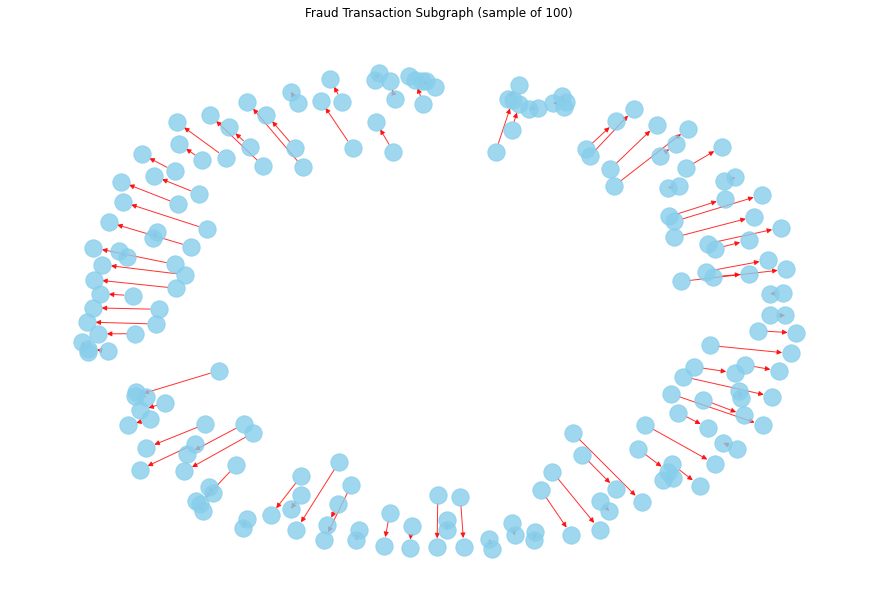

In [0]:

# Sample fraudulent transactions only
fraud_sample = data_imputed_visual.filter("is_fraud = true").limit(100).toPandas()

G = nx.from_pandas_edgelist(
    fraud_sample,
    source='sender_account',
    target='receiver_account',
    edge_attr=['amount', 'timestamp', 'is_fraud'],
    create_using=nx.DiGraph()
)

# Layout and colors
pos = nx.spring_layout(G, seed=42)
edge_colors = ['red' if d['is_fraud'] else 'gray' for _, _, d in G.edges(data=True)]

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=False, node_color='skyblue', edge_color=edge_colors, node_size=300, alpha=0.8)
plt.title("Fraud Transaction Subgraph (sample of 100)")
plt.show()

In [0]:

# Create GraphFrame from Spark DataFrame
edges = data_imputed_visual.selectExpr("sender_account as src", "receiver_account as dst", "is_fraud")
vertices = edges.select("src").union(edges.select("dst")).distinct().withColumnRenamed("src", "id")
g = GraphFrame(vertices, edges)

# Compute degrees
top_senders = g.inDegrees.orderBy("inDegree", ascending=False)
top_senders.show()

top_receivers = g.outDegrees.orderBy("outDegree", ascending=False)
top_receivers.show()


+------+--------+
|    id|inDegree|
+------+--------+
|400278|      23|
|804655|      20|
|452312|      19|
|992780|      19|
|719493|      19|
|324968|      18|
|954459|      18|
|816762|      18|
|743715|      18|
|580358|      18|
|626469|      18|
|917408|      18|
|954845|      18|
|910612|      18|
|961218|      18|
|306162|      18|
|137457|      17|
|807221|      17|
|613536|      17|
|778429|      17|
+------+--------+
only showing top 20 rows

+------+---------+
|    id|outDegree|
+------+---------+
|983922|       20|
|862649|       19|
|931649|       19|
|854997|       19|
|407908|       19|
|138486|       19|
|270812|       18|
|765230|       18|
|854526|       18|
|608413|       18|
|824720|       18|
|372028|       18|
|986628|       18|
|340776|       18|
|291624|       18|
|309339|       18|
|396669|       18|
|505160|       18|
|382656|       18|
|570816|       17|
+------+---------+
only showing top 20 rows



In [0]:

# Filter edges to only fraudulent transactions
fraud_edges = edges.filter(col("is_fraud") == "yes")

# Create vertices from fraud edges
fraud_vertices = fraud_edges.select("src").union(fraud_edges.select("dst")).distinct().withColumnRenamed("src", "id")

# Create fraud GraphFrame
fraud_g = GraphFrame(fraud_vertices, fraud_edges)

# Compute inDegrees (top fraudulent receivers)
top_fraud_receivers = fraud_g.inDegrees.orderBy("inDegree", ascending=False).limit(10)
top_fraud_receivers.show()

# Compute outDegrees (top fraudulent senders)
top_fraud_senders = fraud_g.outDegrees.orderBy("outDegree", ascending=False).limit(10)
top_fraud_senders.show()


+------+--------+
|    id|inDegree|
+------+--------+
|151819|       5|
|522532|       4|
|171224|       4|
|881860|       4|
|959945|       4|
|571015|       4|
|532134|       4|
|402992|       4|
|287154|       4|
|497654|       4|
+------+--------+

+------+---------+
|    id|outDegree|
+------+---------+
|367849|        7|
|651812|        5|
|312579|        5|
|820314|        4|
|953402|        4|
|239462|        4|
|473532|        4|
|595539|        4|
|327703|        4|
|450438|        4|
+------+---------+



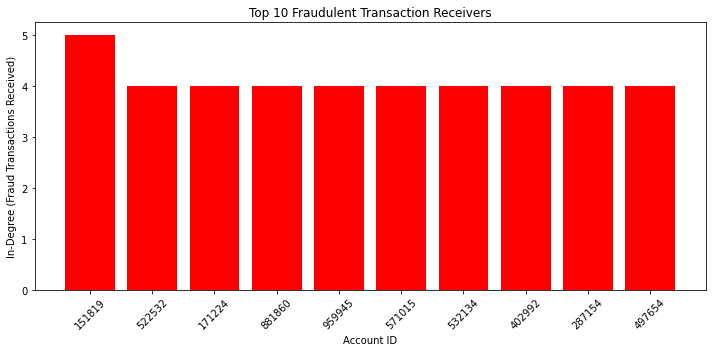

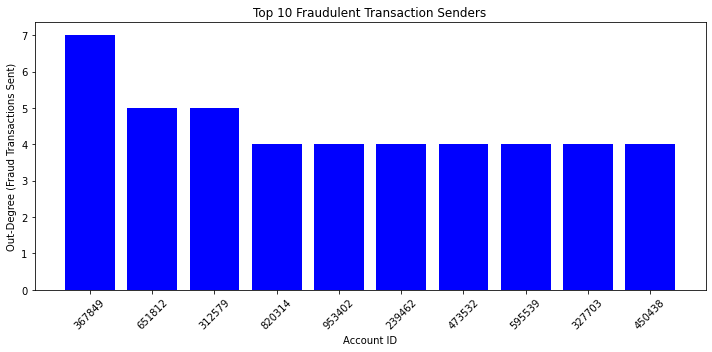

In [0]:

# Collect data to Pandas DataFrames for plotting
top_fraud_receivers_pd = top_fraud_receivers.toPandas()
top_fraud_senders_pd = top_fraud_senders.toPandas()

# Plot Fraudulent Receivers
if not top_fraud_receivers_pd.empty:
    plt.figure(figsize=(10, 5))
    plt.bar(top_fraud_receivers_pd['id'].astype(str), top_fraud_receivers_pd['inDegree'], color='red')
    plt.title("Top 10 Fraudulent Transaction Receivers")
    plt.xlabel("Account ID")
    plt.ylabel("In-Degree (Fraud Transactions Received)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot for fraudulent receivers.")

# Plot Fraudulent Senders
if not top_fraud_senders_pd.empty:
    plt.figure(figsize=(10, 5))
    plt.bar(top_fraud_senders_pd['id'].astype(str), top_fraud_senders_pd['outDegree'], color='blue')
    plt.title("Top 10 Fraudulent Transaction Senders")
    plt.xlabel("Account ID")
    plt.ylabel("Out-Degree (Fraud Transactions Sent)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot for fraudulent senders.")

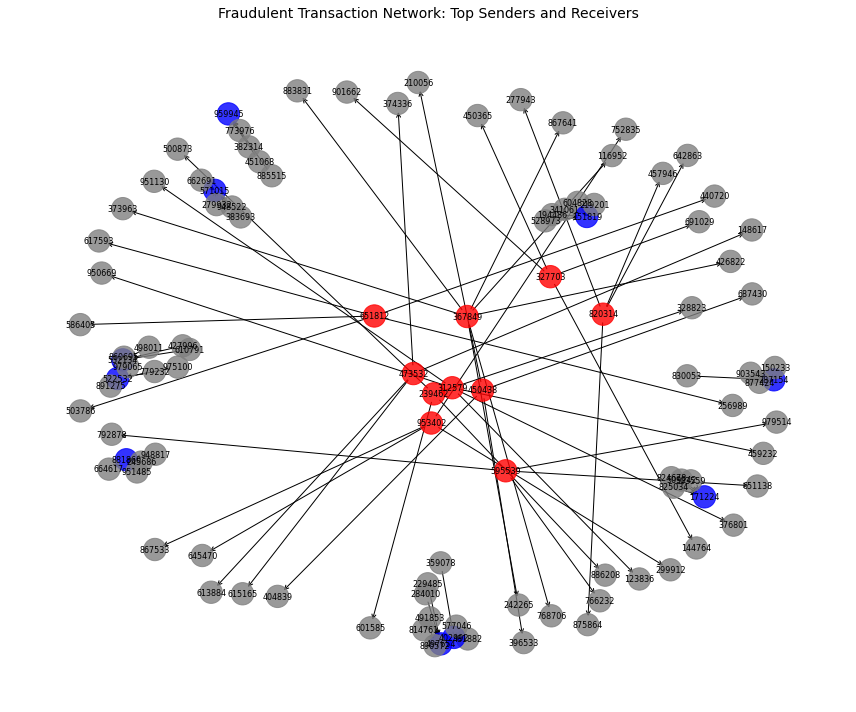

In [0]:

# Collect top sender/receiver IDs
top_sender_ids = set(top_fraud_senders_pd['id'].tolist())
top_receiver_ids = set(top_fraud_receivers_pd['id'].tolist())

# Filter fraud_edges to only include edges involving top senders or receivers
filtered_fraud_edges = fraud_edges.filter(
    (col("src").isin(top_sender_ids)) | (col("dst").isin(top_receiver_ids))
)

# Collect edges to Pandas for plotting
fraud_edges_pd = filtered_fraud_edges.select("src", "dst").toPandas()

# Create directed graph
G = nx.DiGraph()

# Add edges to the graph
for _, row in fraud_edges_pd.iterrows():
    G.add_edge(str(row['src']), str(row['dst']))

# Set node colors: red = top sender, blue = top receiver, purple = both
node_colors = []
for node in G.nodes:
    if int(node) in top_sender_ids and int(node) in top_receiver_ids:
        node_colors.append("purple")
    elif int(node) in top_sender_ids:
        node_colors.append("red")
    elif int(node) in top_receiver_ids:
        node_colors.append("blue")
    else:
        node_colors.append("gray")

# Draw the graph
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)  # Use a layout that spaces out nodes

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, alpha=0.8)
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, edge_color='black', width=1)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Fraudulent Transaction Network: Top Senders and Receivers", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


In [0]:
# Weakly connected components (because it's a DiGraph)
components = list(nx.weakly_connected_components(G))
print(f"Total components: {len(components)}")
print(f"Top 3 component sizes: {[len(c) for c in sorted(components, key=len, reverse=True)[:3]]}")

Total components: 20
Top 3 component sizes: [8, 6, 6]


In [0]:

receiver_map = defaultdict(set)
for u, v in G.edges():
    receiver_map[v].add(u)

# Show receivers with multiple distinct senders
multi_sender_receivers = {k: v for k, v in receiver_map.items() if len(v) > 1}
for r, senders in list(multi_sender_receivers.items())[:5]:
    print(f"Receiver {r} has senders: {list(senders)}")

Receiver 959945 has senders: ['382314', '885515', '773976', '451068']
Receiver 571015 has senders: ['662691', '383693', '948522', '279932']
Receiver 881860 has senders: ['951485', '245686', '664617', '948817']
Receiver 532134 has senders: ['498011', '427996', '979065', '610791']
Receiver 171224 has senders: ['825034', '509242', '824678', '503559']


In [0]:
pos = nx.kamada_kawai_layout(G)

# Example node colors by attribute
node_colors = ['red' if G.nodes[n].get('fraud', False) else 'skyblue' for n in G.nodes()]

# Example edge colors by attribute
edge_colors = ['red' if G.edges[e].get('fraudulent', False) else 'grey' for e in G.edges()]

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=False, node_color=node_colors, edge_color=edge_colors, node_size=300, alpha=0.8)
plt.title("Fraud Subgraph (Kamada-Kawai Layout)")
plt.show()

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
File <command-981273524557954>:1
----> 1 pos = nx.kamada_kawai_layout(G)
      3 # Example node colors by attribute
      4 node_colors = ['red' if G.nodes[n].get('fraud', False) else 'skyblue' for n in G.nodes()]

File /local_disk0/.ephemeral_nfs/envs/pythonEnv-8c4b342d-0efd-45d4-bda3-b5c29dfc273d/lib/python3.9/site-packages/networkx/drawing/layout.py:709, in kamada_kawai_layout(G, dist, pos, weight, scale, center, dim)
    706         pos = dict(zip(G, np.linspace(0, 1, len(G))))
    707 pos_arr = np.array([pos[n] for n in G])
--> 709 pos = _kamada_kawai_solve(dist_mtx, pos_arr, dim)
    711 pos = rescale_layout(pos, scale=scale) + center
    712 return dict(zip(G, pos))

File /local_disk0/.ephemeral_nfs/envs/pythonEnv-8c4b342d-0efd-45d4-bda3-b5c29dfc273d/lib/python3.9/site-packages/networkx/drawing/layout.py:726, in _kamada_kawai_sol

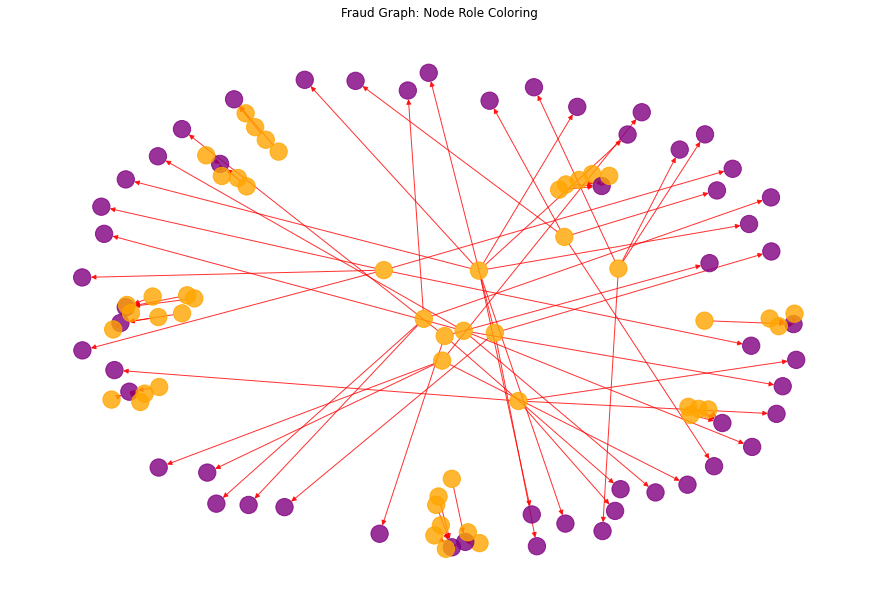

In [0]:
# Classify nodes
node_roles = {}
for node in G.nodes():
    indeg = G.in_degree(node)
    outdeg = G.out_degree(node)
    if outdeg > indeg:
        node_roles[node] = 'sender'
    elif indeg > outdeg:
        node_roles[node] = 'receiver'
    else:
        node_roles[node] = 'neutral'

# Map to colors
color_map = {'sender': 'orange', 'receiver': 'purple', 'neutral': 'lightblue'}
node_colors = [color_map[node_roles[n]] for n in G.nodes()]

# Plot
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=False, node_color=node_colors, edge_color=edge_colors, node_size=300, alpha=0.8)
plt.title("Fraud Graph: Node Role Coloring")
plt.show()

In [0]:
# Combine in-degree and out-degree
in_deg = g.inDegrees
out_deg = g.outDegrees

centrality = in_deg.join(out_deg, "id", "outer").fillna(0) \
    .withColumn("degree_centrality", F.col("inDegree") + F.col("outDegree")) \
    .orderBy(F.desc("degree_centrality"))

centrality.display()


id,inDegree,outDegree,degree_centrality
992780,19,11,30
742599,12,17,29
961218,18,11,29
804655,20,9,29
340776,11,18,29
400278,23,5,28
983922,8,20,28
535780,16,12,28
464114,15,13,28
845416,16,12,28


In [0]:
daily_fraud = data_imputed_visual.groupBy(F.window("timestamp", "1 day")) \
    .agg(F.count("*").alias("total_tx"), F.sum(F.col("is_fraud").cast("int")).alias("fraud_tx")) \
    .select("window.start", "total_tx", "fraud_tx") \
    .orderBy("start")

daily_fraud.display()

start,total_tx,fraud_tx
2023-01-01T00:00:00.000+0000,7285,252
2023-01-02T00:00:00.000+0000,13740,477
2023-01-03T00:00:00.000+0000,13560,494
2023-01-04T00:00:00.000+0000,13785,465
2023-01-05T00:00:00.000+0000,13810,494
2023-01-06T00:00:00.000+0000,13581,451
2023-01-07T00:00:00.000+0000,13626,475
2023-01-08T00:00:00.000+0000,13663,489
2023-01-09T00:00:00.000+0000,13545,472
2023-01-10T00:00:00.000+0000,13541,488


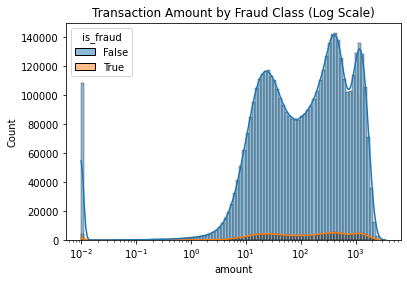

In [0]:

data_pandas = data.toPandas()
sns.histplot(data = data_pandas, x = "amount", hue = "is_fraud", log_scale = True, bins = 100, kde = True)
plt.title("Transaction Amount by Fraud Class (Log Scale)")
plt.show()

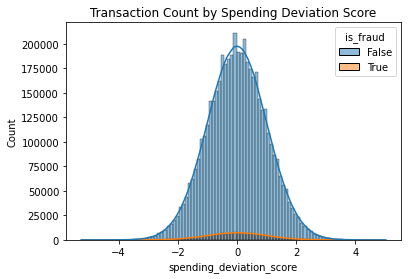

In [0]:
sns.histplot(data = data_pandas, x = "spending_deviation_score", hue = "is_fraud", bins = 100, kde = True)
plt.title("Transaction Count by Spending Deviation Score")
plt.show()

/databricks/python/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Out[103]: <AxesSubplot:xlabel='time_since_last_transaction', ylabel='Count'>

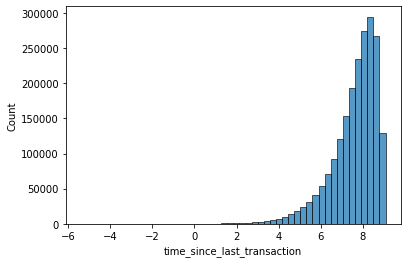

In [0]:
sns.histplot(np.log1p(data_pandas['time_since_last_transaction']), bins=50)

Out[77]: <AxesSubplot:xlabel='geo_anomaly_score', ylabel='Density'>

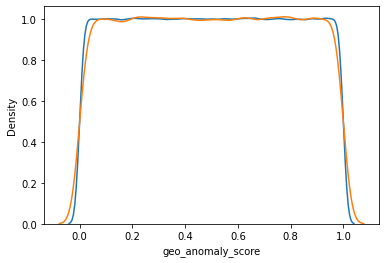

In [0]:
sns.kdeplot(data_pandas[data_pandas['is_fraud'] == 0]['geo_anomaly_score'], label='Legit')
sns.kdeplot(data_pandas[data_pandas['is_fraud'] == 1]['geo_anomaly_score'], label='Fraud')

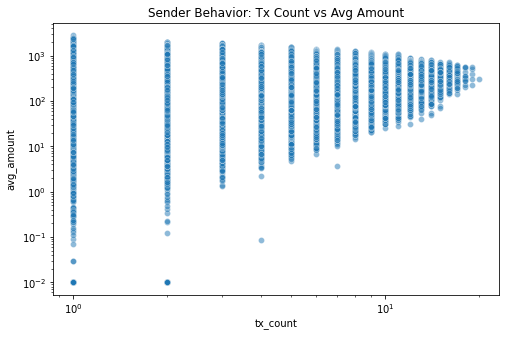

In [0]:
sender_stats = df.groupBy("sender_account") \
    .agg(
        F.count("*").alias("tx_count"),
        F.avg("amount").alias("avg_amount")
    ).toPandas()

plt.figure(figsize=(8, 5))
sns.scatterplot(data=sender_stats, x="tx_count", y="avg_amount", alpha=0.5)
plt.xscale("log")
plt.yscale("log")
plt.title("Sender Behavior: Tx Count vs Avg Amount")
plt.show()


### 7. Feature enrichment

#### 7.1 Time-derived columns

In [0]:
df_feat = (data_imputed
  .withColumn("hour_of_day",  hour("event_time"))
  .withColumn("day_of_week",  dayofweek("event_time"))   # 1=Sun … 7=Sat
  .withColumn("is_weekend",   when(dayofweek("event_time").isin(1,7), 1).otherwise(0))
  .withColumn("month",        month("event_time"))
)

| New col.      | Granularity | Typical signal in fraud                     |
| ------------- | ----------- | ------------------------------------------- |
| `hour_of_day` | 0-23        | Late-night spikes, odd sleep-cycle activity |
| `day_of_week` | 1-7         | Friday-night / Sunday-evening anomalies     |
| `is_weekend`  | binary      | Simple high-impact flag                     |
| `month`       | 1-12        | Seasonality (Black-Friday, holidays)        |


These velocity and burstiness indicators often separate fraud rings from normal users far better than static attributes (merchant, device…). Adding them early means they can be indexed/ cached once and reused by every downstream model.

#### 7.2 Rolling behavioural metrics

In [0]:
# Prepare a UNIX-seconds column for easy range windows
df_ts = df_feat.withColumn("ts_sec", unix_timestamp("event_time"))

# Define windows (all ordered by event_time within each sender)
w_1h  = Window.partitionBy("sender_account").orderBy("ts_sec") \
              .rangeBetween(-3600, -1)
w_24h = Window.partitionBy("sender_account").orderBy("ts_sec") \
              .rangeBetween(-86400, -1)
w_7d  = Window.partitionBy("sender_account").orderBy("ts_sec") \
              .rangeBetween(-86400*7, -1)
w_last10 = Window.partitionBy("sender_account").orderBy("ts_sec") \
                 .rowsBetween(-10, -1)

# Add rolling columns
df_roll = (df_ts
  .withColumn("txns_1h",  count("*").over(w_1h))
  .withColumn("amt_24h",  _sum("amount").over(w_24h))
  .withColumn("uniq_rcv_7d", approx_count_distinct("receiver_account").over(w_7d))
  # gap mins: difference between successive txns
  .withColumn("prev_ts",  lag("ts_sec", 1).over(Window.partitionBy("sender_account")
                                               .orderBy("ts_sec")))
  .withColumn("gap_mins", (col("ts_sec") - col("prev_ts"))/60.0)
  .withColumn("avg_gap_mins_10", avg("gap_mins").over(w_last10))
  # zero-fill NULLs on first transactions
  .na.fill({"txns_1h": 0, "amt_24h": 0.0, "uniq_rcv_7d": 0,
            "avg_gap_mins_10": 9999.0})
  .drop("prev_ts", "gap_mins", "ts_sec")
)

df_roll.select("sender_account", "event_time", "amount",
               "txns_1h", "amt_24h", "uniq_rcv_7d",
               "avg_gap_mins_10").show(5, truncate=False)


+--------------+--------------------------+-------+-------+-------+-----------+------------------+
|sender_account|event_time                |amount |txns_1h|amt_24h|uniq_rcv_7d|avg_gap_mins_10   |
+--------------+--------------------------+-------+-------+-------+-----------+------------------+
|ACC100003     |2023-04-13 14:38:00.52001 |16.19  |0      |0.0    |0          |9999.0            |
|ACC100003     |2023-04-30 03:53:31.626724|1200.48|0      |0.0    |0          |9999.0            |
|ACC100003     |2023-05-21 00:57:48.160305|376.23 |0      |0.0    |0          |23835.516666666666|
|ACC100003     |2023-08-25 17:15:09.84297 |242.04 |0      |0.0    |0          |26949.9           |
|ACC100003     |2023-09-03 12:28:39.396761|925.5  |0      |0.0    |0          |64372.38333333334 |
+--------------+--------------------------+-------+-------+-------+-----------+------------------+
only showing top 5 rows



### 8. Pipeline

In [0]:
df_roll.limit(10).display()

transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,event_time,time_since_last_tx_tmp,time_since_last_transaction_imp,hour_of_day,day_of_week,is_weekend,month,txns_1h,amt_24h,uniq_rcv_7d,avg_gap_mins_10
T1170676,2023-04-13T14:38:00.520+0000,ACC100003,ACC195443,16.19,transfer,grocery,New York,mobile,false,-3218.619256377778,0.12,1.0,0.1,wire_transfer,184.22.170.215,D8945075,2023-04-13T14:38:00.520+0000,3218.619256377778,3218.619256377778,14,5,0,4,0,0.0,0,9999.0
T1003981,2023-04-30T03:53:31.626+0000,ACC100003,ACC603214,1200.48,deposit,restaurant,Sydney,pos,false,null,0.89,14.0,0.37,UPI,4.177.7.251,D3263783,2023-04-30T03:53:31.626+0000,null,2566.543702108889,3,1,1,4,0,0.0,0,9999.0
T3303332,2023-05-21T00:57:48.160+0000,ACC100003,ACC635752,376.23,withdrawal,retail,London,web,false,-5164.552279159444,0.26,17.0,0.59,UPI,65.2.227.169,D9077572,2023-05-21T00:57:48.160+0000,5164.552279159444,5164.552279159444,0,1,1,5,0,0.0,0,23835.516666666666
T1149234,2023-08-25T17:15:09.842+0000,ACC100003,ACC107883,242.04,payment,retail,New York,mobile,false,-211.22487605305557,0.37,16.0,0.06,UPI,137.154.146.174,D2046783,2023-08-25T17:15:09.842+0000,211.22487605305557,211.22487605305557,17,6,0,8,0,0.0,0,26949.9
T1018914,2023-09-03T12:28:39.396+0000,ACC100003,ACC204438,925.5,deposit,other,Berlin,mobile,false,3032.585491676944,-0.4,16.0,0.38,UPI,13.68.170.193,D3989703,2023-09-03T12:28:39.396+0000,3032.585491676944,3032.585491676944,12,1,1,9,0,0.0,0,64372.38333333334
T4836104,2023-12-04T04:56:39.076+0000,ACC100003,ACC316067,87.02,payment,restaurant,Singapore,web,false,4731.980809944166,-0.82,19.0,0.39,ACH,172.183.210.108,D7287276,2023-12-04T04:56:39.076+0000,4731.980809944166,4731.980809944166,4,2,0,12,0,0.0,0,51447.662500000006
T1997184,2023-12-22T05:30:56.365+0000,ACC100003,ACC672980,90.72,payment,restaurant,Berlin,mobile,false,6062.882179241388,-1.25,14.0,0.74,card,18.59.0.96,D5812741,2023-12-22T05:30:56.365+0000,6062.882179241388,6062.882179241388,5,6,0,12,0,0.0,0,67563.73000000001
T4421291,2023-01-05T18:16:39.685+0000,ACC100016,ACC292179,15.02,transfer,grocery,Sydney,mobile,false,-6563.549407569167,1.11,4.0,0.87,ACH,13.244.135.228,D1144030,2023-01-05T18:16:39.685+0000,6563.549407569167,6563.549407569167,18,5,0,1,0,0.0,0,9999.0
T3674154,2023-10-06T05:49:37.552+0000,ACC100016,ACC324167,112.71,withdrawal,travel,London,pos,false,-495.2550474727778,0.43,6.0,0.52,wire_transfer,201.241.136.239,D6627996,2023-10-06T05:49:37.552+0000,495.2550474727778,495.2550474727778,5,6,0,10,0,0.0,0,9999.0
T1674210,2023-10-26T21:04:55.723+0000,ACC100016,ACC862571,221.71,withdrawal,other,Berlin,pos,false,null,-0.04,18.0,0.35,ACH,7.181.248.86,D9962992,2023-10-26T21:04:55.723+0000,null,2566.543702108889,21,5,0,10,0,0.0,0,393812.9666666667


In [0]:
df_roll.printSchema()

root
 |-- transaction_id: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- sender_account: string (nullable = true)
 |-- receiver_account: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- merchant_category: string (nullable = true)
 |-- location: string (nullable = true)
 |-- device_used: string (nullable = true)
 |-- is_fraud: boolean (nullable = true)
 |-- time_since_last_transaction: double (nullable = true)
 |-- spending_deviation_score: double (nullable = true)
 |-- velocity_score: double (nullable = true)
 |-- geo_anomaly_score: double (nullable = true)
 |-- payment_channel: string (nullable = true)
 |-- ip_address: string (nullable = true)
 |-- device_hash: string (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- time_since_last_tx_tmp: double (nullable = true)
 |-- time_since_last_transaction_imp: double (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |--

#### 8.1 Define final variable columns

In [0]:
# Numeric feature columns
num_cols = [
    # “raw” numeric signals
    "amount",
    "spending_deviation_score",
    "velocity_score",
    "geo_anomaly_score",
    "time_since_last_transaction_imp",
    # rolling / behavioural features
    "txns_1h",
    "amt_24h",
    "uniq_rcv_7d",
    "avg_gap_mins_10",
]

# Low-cardinality categoricals
cat_cols = [
    # business / transaction attrs
    "transaction_type",
    "merchant_category",
    "location",
    "device_used",
    "payment_channel",
    # calendar attrs
    "hour_of_day",
    "day_of_week",
    "is_weekend",
    "month",
]

# High-cardinality IDs
# sender_account, receiver_account  → frequency-encode or hash
# ip_address, device_hash           → hash (/24 bucket) or drop
high_card_ids = ["sender_account", "receiver_account",
                 "ip_address", "device_hash"]

# Pure primary-key column to drop
drop_cols = ["transaction_id",
             "time_since_last_transaction",  # raw & superseded
             "time_since_last_tx_tmp",       # temp column
             "timestamp", "event_time"]      # keep only if you need in inference



#### 8.2 Create log transformations

To improve model performance and numerical stability, we apply a log-transformation to skewed numeric features—specifically `amount` and `time_since_last_transaction_imp`. These variables have long-tailed distributions that can negatively impact the learning of certain model types.

We use `SQLTransformer` to apply `log1p(x)` (which computes `log(1 + x)`) and create the following new features:

- `log_amount`  
- `log_time_since_last_tx`

These are added **in addition to** the original features when training tree-based models such as Gradient-Boosted Trees, which are generally robust to skew and may benefit from both representations.

For **linear or distance-based models** (e.g., logistic regression, k-NN), which are more sensitive to feature scaling and skewness, we create an alternate numeric column set that **excludes** the original `amount` and `time_since_last_transaction_imp`, replacing them with their log-transformed counterparts:

```python
num_cols_ext_linear_base_models = num_cols_mod + ["log_amount", "log_time_since_last_tx"]


In [0]:
log_amount_sql = SQLTransformer(
    statement="SELECT *, log1p(amount) AS log_amount FROM __THIS__"
)

log_ts_sql = SQLTransformer(
    statement="SELECT *, log1p(time_since_last_transaction_imp) AS log_time_since_last_tx FROM __THIS__"
)

num_cols_ext = num_cols + ["log_amount", "log_time_since_last_tx"] 


# For linear/ distance-based models
num_cols_mod = [c for c in num_cols
                if c not in ("amount", "time_since_last_transaction_imp")]
num_cols_ext_linear_base_models = num_cols_mod + ["log_amount", "log_time_since_last_tx"]




#### 8.3 Low cardinality categorical features

  
To convert categorical features into a numerical format suitable for machine learning algorithms, we apply a two-step encoding process:

1. **`StringIndexer`**: Converts each categorical value into a numeric index. This is necessary because most ML algorithms cannot directly handle string-type inputs.

2. **`OneHotEncoder`**: Transforms indexed categories into sparse binary vectors. For example, a feature with 4 categories will be represented as a 4-dimensional vector where only one element is `1.0` and the rest are `0.0`.

We configure:

- `handleInvalid="keep"` in `StringIndexer` to ensure that any unseen category in validation/test data is assigned a default bucket.
- `dropLast=False` in `OneHotEncoder` to retain all categories (important for tree-based models that can handle redundancy well).

This encoding process is applied to all features in the `cat_cols` list, and the resulting columns (e.g., `device_type_ohe`, `payment_channel_ohe`, etc.) are stored in `ohe_cols` for later use in the `VectorAssembler`.


In [0]:
indexers = [StringIndexer(inputCol=c,
                          outputCol=f"{c}_idx",
                          handleInvalid="keep")
            for c in cat_cols]

encoders = [OneHotEncoder(inputCol=idx.getOutputCol(),
                          outputCol=f"{idx.getOutputCol()}_ohe",
                          dropLast=False)
            for idx in indexers]

ohe_cols = [e.getOutputCol() for e in encoders]


#### 8.4 High cardnality IDs


Some categorical features, such as `sender_account` and `receiver_account`, have **very high cardinality** (hundreds of thousands of unique values). Applying traditional one-hot encoding to such features would result in extremely sparse and wide feature vectors, which is computationally expensive and prone to overfitting.

To address this, we use **`FeatureHasher`** to convert high-cardinality string features into fixed-length numerical vectors. This approach:

- Projects the categorical input into a lower-dimensional hashed feature space.
- Retains some of the identity signal while keeping the feature space compact.
- Avoids the explosion of dimensions caused by one-hot encoding.

In this project, we hash both `sender_account` and `receiver_account` into 1,024-dimensional vectors using the following configuration:


In [0]:
hasher_sender = FeatureHasher(inputCols=["sender_account"],
                              outputCol="sender_hash",
                              numFeatures=1024)
hasher_receiver = FeatureHasher(inputCols=["receiver_account"],
                                outputCol="receiver_hash",
                                numFeatures=1024)

num_cols_mod = num_cols_mod + ["sender_hash", "receiver_hash"]

num_cols_ext_linear_base_models = num_cols_ext_linear_base_models + ["sender_hash", "receiver_hash"]


#### 8.5 VectorAssembler -> StandardScaler


After applying various transformations to numeric, categorical, and high-cardinality features, we need to **consolidate all input features into a single vector column** for model consumption. This is done using two final steps:

1. **`VectorAssembler`**: Combines all selected features—numerical, log-transformed, hashed IDs, and one-hot encoded categoricals—into a single vector column called `features_raw`.

2. **`StandardScaler`**: Normalizes the `features_raw` vector by scaling each feature to have unit standard deviation. This is particularly useful for models that are sensitive to feature magnitude (e.g., logistic regression, neural networks). Although tree-based models are usually invariant to scale, applying `StandardScaler` ensures compatibility and consistency across different model types.



In [0]:
assembler = VectorAssembler(
    inputCols=num_cols_ext + ["sender_hash", "receiver_hash"] + ohe_cols,
    outputCol="features_raw"
)

scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withStd=True, withMean=False
)

#### 8.6 Label and weight columns 


In order to train supervised machine learning models in Spark, we must provide two special columns:

- `label`: the target column representing the outcome to predict (in our case, whether a transaction is fraudulent). Spark ML requires this column to be of type `double`.
- `weight`: an optional column used to give **more importance to rare classes** during training. This is especially important in imbalanced classification tasks like fraud detection.

Since fraud occurs in roughly **3–4% of transactions**, we compute a **class weight ratio of 26:1** and assign:

- `weight = 26.0` to fraud rows (`is_fraud = True`)
- `weight = 1.0` to non-fraud rows (`is_fraud = False`)

This helps the model treat the minority class more seriously during training.


In [0]:
df_final = df_roll.withColumn("label", col("is_fraud").cast("double")) \
                  .withColumn("weight",
                              when(col("is_fraud"), 26.0).otherwise(1.0))

#### 8.7 Assembling the Pipeline


To ensure consistency and reproducibility across training, validation, and test datasets, we consolidate all preprocessing steps into a single Spark ML `Pipeline`. This approach guarantees that the exact same transformations are applied to any incoming data, both during model development and in production.

The pipeline includes the following stages, in order:

1. **Log-transforms** for skewed numeric features (`log_amount`, `log_time_since_last_tx`)
2. **Feature hashing** for high-cardinality categorical variables (`sender_account`, `receiver_account`)
3. **String indexing and one-hot encoding** for low-cardinality categorical variables
4. **Vector assembly** to combine all features into a single `features_raw` column
5. **Standard scaling** to normalize the `features_raw` vector into a final `features` column

In [0]:
stages = [
    log_amount_sql,
    log_ts_sql,
    hasher_sender,
    hasher_receiver,
] + indexers + encoders + [
    assembler,
    scaler
]

full_pipeline = Pipeline(stages=stages)


#### 8.8 Time-based Train / Val / Test split
Because our data span March → October 2023, split chronologically so the model is evaluated on future behaviour:

##### 8.8.1 Why a chrono-split?

- **Goal:** mimic real-world deployment by training on the past and validating on unseen future data.

- **Ratios:** 70 % / 15 % / 15 % chosen to balance training volume with robust validation.

- **Method:** find the dates where the cumulative row count reaches 70 % and 85 %.


##### 8.8.2 Helper

In [0]:
def find_chrono_split(df,
                      ts_col="event_time",
                      train_frac=0.70,
                      val_frac=0.15):
    """
    Inspect df[ts_col] and return 3 boundary dates such that
    rows <  train_cut     ≈ train_frac
    train_cut ≤ rows < val_cut ≈ val_frac
    rows ≥ val_cut        ≈ 1 - train_frac - val_frac   (test set)

    Returns (train_cut_date, val_cut_date, counts_dict)
    """

    # Collapse to one row per day
    by_day = (df.withColumn("day", to_date(col(ts_col)))
                .groupBy("day")
                .agg(count("*").alias("rows"))
                .orderBy("day"))

    total_rows = by_day.agg(_sum("rows")).first()[0]

    # Cumulative % over time
    w = Window.orderBy("day").rowsBetween(Window.unboundedPreceding, 0)
    by_day = (by_day
              .withColumn("cum_rows", _sum("rows").over(w))
              .withColumn("cum_pct",  col("cum_rows") / lit(total_rows)))

    # Pick first day where cum_pct >= thresholds
    train_cut  = (by_day.filter(col("cum_pct") >= train_frac)
                          .select("day")
                          .first()[0])
    val_cut    = (by_day.filter(col("cum_pct") >= train_frac + val_frac)
                          .select("day")
                          .first()[0])

    # Quick sanity counts
    train_cnt = df.filter(col(ts_col) <  train_cut).count()
    val_cnt   = df.filter((col(ts_col) >= train_cut) & (col(ts_col) < val_cut)).count()
    test_cnt  = df.filter(col(ts_col) >= val_cut).count()

    counts = {"train": train_cnt, "val": val_cnt, "test": test_cnt,
              "total": total_rows}

    return train_cut, val_cut, counts


##### 8.8.3 Compute split boundaries


In [0]:
train_cut, val_cut, counts = find_chrono_split(df_final)

print("Automatic split boundaries:")
print("  • train < ", train_cut)
print("  • val   : [", train_cut, ",", val_cut, ")")
print("  • test  ≥", val_cut)
print("Row counts:", counts)

Automatic split boundaries:
  • train <  2023-09-14
  • val   : [ 2023-09-14 , 2023-11-07 )
  • test  ≥ 2023-11-07
Row counts: {'train': 3499548, 'val': 740619, 'test': 759833, 'total': 5000000}


##### 8.8.4 Materialising train_df, val_df, test_df


In [0]:
train_df = df_final.filter(col("event_time") <  train_cut)
val_df   = df_final.filter((col("event_time") >= train_cut) &
                           (col("event_time") <  val_cut))
test_df  = df_final.filter(col("event_time") >= val_cut)

print("Train rows :", train_df.count())
print("Val rows   :", val_df.count())
print("Test rows  :", test_df.count())

Train rows : 3499548
Val rows   : 740619
Test rows  : 759833


##### 8.8.5 Quick leakage sanity-check

Verify no sender accounts appear for the first time in validation or test.

In [0]:
first_seen_train = train_df.select("sender_account").distinct()
val_new_accounts = (val_df
                    .join(first_seen_train, "sender_account", "left_anti")
                    .count())

print("Brand-new accounts in val set:", val_new_accounts)


Brand-new accounts in val set: 15287


How many transactions involve these 15287 new sender?

In [0]:
val_cold_rows = (val_df
                 .join(first_seen_train, "sender_account", "left_anti")
                 .count())
print("Transactions from brand-new accounts:", val_cold_rows)
print(f"Share of val rows: {val_cold_rows/740_619:.2%}")

Transactions from brand-new accounts: 15287
Share of val rows: 2.06%


Fraud counts per split

In [0]:
def fraud_share(df, name):
    total  = df.count()
    fraud  = df.filter("is_fraud").count()
    print(f"{name:<5} | rows = {total:,}  | fraud % = {fraud/total*100:5.2f}")

for frame, label in [(train_df, "Train"),
                     (val_df,   "Val"),
                     (test_df,  "Test")]:
    fraud_share(frame, label)


Train | rows = 3,499,548  | fraud % =  3.58
Val   | rows = 740,619  | fraud % =  3.60
Test  | rows = 759,833  | fraud % =  3.61


### 9. Model training and evaluation

#### 9.1 Prepare target and weights

In [0]:
# Cast the target → "label", then add the weight column
train_df = (train_df
            .withColumn("label",  F.col("is_fraud").cast("double"))
            .withColumn("weight", F.when(F.col("is_fraud"), 26.0)     
                                   .otherwise(1.0)))

val_df  = val_df .withColumn("label", F.col("is_fraud").cast("double"))
test_df = test_df.withColumn("label", F.col("is_fraud").cast("double"))


Why 26 ? -> from our quick stats, fraud ≈ 3.8 % → ratio ≈ 1 : 26.
Giving minority rows a weight equal to that ratio makes the loss treat both classes roughly equally.

#### 9.2 Fit the pre-processing pipeline and transform every split


In [0]:
# Fitting the pipeline on TRAIN only
preproc_model = full_pipeline.fit(train_df)

# Transforming all three splits once and cache the results
train_ready = preproc_model.transform(train_df).cache()
val_ready   = preproc_model.transform(val_df).cache()
test_ready  = preproc_model.transform(test_df).cache()

# Quick sanity: making sure the vector column exists
print("Train schema:")
train_ready.select("features", "label", "weight").printSchema()
print("Train rows:", train_ready.count(),
      "  Val rows:", val_ready.count(),
      "  Test rows:", test_ready.count())


Train schema:
root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)
 |-- weight: double (nullable = false)

Train rows: 3499548   Val rows: 740619   Test rows: 759833


#### 9.3 Feature Selection


In [0]:
# # ------------------------------------------------------------------
# # 8.4 🔎  Feature-importance selection (index-only fallback)
# # ------------------------------------------------------------------
# from pyspark.ml.classification import RandomForestClassifier
# from pyspark.ml.feature        import VectorSlicer
# import numpy as np

# # --- 1. quick Random Forest on processed data ---------------------
# rf = RandomForestClassifier(
#         featuresCol="features",
#         labelCol="label",
#         weightCol="weight",
#         numTrees=100,
#         maxDepth=6,
#         seed=42)

# rf_model = rf.fit(train_ready)

# # --- 2. grab importances and pick top-10 indices ------------------
# imp = rf_model.featureImportances.toArray()
# top_k = 10
# top_idx = np.argsort(imp)[::-1][:top_k].tolist()

# print("Top-10 feature indices:", top_idx)

# # --- 3. build a VectorSlicer to keep only those dimensions --------
# from pyspark.ml.feature import VectorSlicer
# slicer = VectorSlicer(inputCol="features",
#                       outputCol="features_topK",
#                       indices=top_idx)


In [0]:
# meta = train_ready.schema["features"].metadata
# attrs = []

# for group in ["numeric", "binary", "categorical"]:
#     if "ml_attr" in meta and group in meta["ml_attr"].get("attrs", {}):
#         attrs += meta["ml_attr"]["attrs"][group]

# name_by_index = [attr["name"] for attr in sorted(attrs, key=lambda x: x["idx"])]

# # Now print the top-10 features by name
# for i in top_idx:
#     name = name_by_index[i] if i < len(name_by_index) else f"<hashed_{i}>"
#     print(f"Index {i}: {name}")


#### 9.4 Persist artefacts and exit session


In [0]:
# # 1) --- Fit and save the slicer as a pipeline --------------------

# slicer_pipe = Pipeline(stages=[slicer])
# slicer_model = slicer_pipe.fit(train_ready)

In [0]:
# # 1) --- Fit and save the slicer as a pipeline --------------------

# slicer_pipe = Pipeline(stages=[slicer])
# slicer_model = slicer_pipe.fit(train_ready)
# slicer_model.write().overwrite().save("/FileStore/models/slicer_top10")

# 2) --- Persist preprocessing pipeline + ready data --------------
preproc_model.write().overwrite().save("/FileStore/models/preproc_model")

train_ready.write.format("delta").mode("overwrite").save("/FileStore/data/train_ready")
val_ready  .write.format("delta").mode("overwrite").save("/FileStore/data/val_ready")
test_ready .write.format("delta").mode("overwrite").save("/FileStore/data/test_ready")

print("✅ Saved preproc pipeline, fitted slicer, and ready datasets.")


✅ Saved preproc pipeline, fitted slicer, and ready datasets.


In [0]:
dbutils.fs.ls("/FileStore/models/slicer_top10/")

Out[102]: [FileInfo(path='dbfs:/FileStore/models/slicer_top10/metadata/', name='metadata/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/models/slicer_top10/stages/', name='stages/', size=0, modificationTime=0)]